In [44]:
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import re
from lifelines import KaplanMeierFitter


## Global params and functions

In [48]:
# Load the Excel file
FILEPATH = r"C:\Users\User\OneDrive\Documents\Udem\SciNeurotech\Toronto_project\DBS_Torontov2.xlsx"
EXCEL_DATA = pd.ExcelFile(FILEPATH)



In [49]:
def simple_barplot(df, cols):

    fig, axs = plt.subplots(1, len(cols), figsize=(20, 8))
    for i in range (len(cols)):

        counts = df[cols[i]].dropna().value_counts()
        axs[i].bar(counts.index, counts.values, width=0.4, edgecolor="white", linewidth=0.7)
        axs[i].set_title(f'Bar graph of {cols[i]}')


    plt.tight_layout()
    plt.show()

def print_side_effects(df):

    side_effects = df[~df['Notes'].astype(str).str.contains('baseline', case=False, na=False)]['Notes'].value_counts()
    print(f'Side effects: \n{side_effects}')

def convert_time_to_minutes(time):
    if isinstance(time, str):
        if '.' in time:
            parts = re.split(r'[.:]', time)
            if len(parts) == 3:
                # Format "H.MM.SS" -> Convert to minutes
                hours, minutes, seconds = int(parts[0]), int(parts[1]), int(parts[2])
                total_minutes = hours * 60 + minutes + seconds / 60
                return total_minutes
            elif len(parts) == 2:
                # Format "MM.SS" -> Convert to minutes
                minutes, seconds = int(parts[0]), int(parts[1])
                return minutes + seconds / 60
        elif time.isnumeric():
            # Already in minutes
            return float(time)
    return float(time)

def temporal_graph(df, sheet_name, symptom):
    """
    Get's the temporal evolutionn of a symptom for a given experiment.
    """
    #print(df.loc[(df['Sheet Name'] == sheet_name)]).copy()
    df_filtered = df.loc[(df['Sheet Name'] == sheet_name) & (df['Time'] != -1)].copy()
    df_filtered['Time_filtered'] = df_filtered['Time'].apply(convert_time_to_minutes)

    # Plot the symptom over time
    plt.figure(figsize=(10, 6))
    plt.plot(df_filtered['Time_filtered'], df_filtered[symptom], marker='o', linestyle='-')
    plt.xlabel('Time (minutes)')
    plt.ylabel(symptom)
    plt.title(f'Temporal Evolution of {symptom} for {sheet_name}')
    plt.grid(True)
    plt.show()
    pass

def survival_plots(dfs, sheet, symptom, death_value):

    df = pd.concat(dfs, ignore_index=True)
    df = df.loc[(df['Sheet Name'] == sheet)].copy()
    df = df[[symptom, 'Param']].dropna(subset=[symptom, 'Param'])
    df['event'] = df[symptom] == death_value

    durations = df['Param']
    events = df['event']
    # Instantiate the KaplanMeierFitter and fit the data
    kmf = KaplanMeierFitter()
    kmf.fit(durations, event_observed=events)

    # Plot the survival curve
    kmf.plot_survival_function()
    plt.title(f"Survival Plot of {sheet}")
    plt.xlabel(f"Parameter {sheet}")
    plt.ylabel(f"Survival Probability for {symptom} == {death_value}")
    plt.grid(True)
    plt.show()


def survival(dfs, sheet, death_value):

    df = pd.concat(dfs, ignore_index=True)
    df = df.loc[(df['Sheet Name'] == sheet)].copy()
    df = df[['Param', 'Notes']].dropna(subset=['Param'])
    df['event'] = df['Notes'].fillna(0).apply(lambda x: 1 if x != 0 else 0)
    for index, content in enumerate(df['event']):

        if index == 0:
            continue
        if content == 1:
            df.loc[index, 'event'] = 0
            df.loc[index - 1, 'event'] = 1


    print(df['Param'].isnull().value_counts())

    durations = df['Param'].fillna(0)
    events = df['event']
    # Instantiate the KaplanMeierFitter and fit the data
    kmf = KaplanMeierFitter()
    kmf.fit(durations, event_observed=events)

    # Plot the survival curve
    kmf.plot_survival_function()
    plt.title(f"Survival Plot of {sheet}")
    plt.xlabel(f"Parameter {sheet}")
    plt.ylabel(f"Survival Probability")
    plt.grid(True)
    plt.show()




# Extracting each patient dataframes

In [69]:
GP3_df = pd.read_excel(EXCEL_DATA, EXCEL_DATA.sheet_names[0])
STN1_df = pd.read_excel(EXCEL_DATA, EXCEL_DATA.sheet_names[1])
STN2_df = pd.read_excel(EXCEL_DATA, EXCEL_DATA.sheet_names[2])
STN3_df = pd.read_excel(EXCEL_DATA, EXCEL_DATA.sheet_names[3])
STN4_df = pd.read_excel(EXCEL_DATA, EXCEL_DATA.sheet_names[4])
STN5_df = pd.read_excel(EXCEL_DATA, EXCEL_DATA.sheet_names[5])
STN6_df = pd.read_excel(EXCEL_DATA, EXCEL_DATA.sheet_names[6])


## Simple visualization

In [51]:
STN1_df.head(10)

,Test,L Finger Tap,R Finger Tap,L Rigidity,R Rigidity,L Rest Trem,R Rest Trem,Speech,Spiral,Notes,Time,Param,Sheet Name
0,0,2.0,3.0,2.0,1.0,2.0,1.0,2.0,0.0,-2,NaN,NaN,Baseline
1,1,2.0,3.0,2.0,1.0,2.0,1.0,2.0,NaN,2,NaN,NaN,Baseline
2,64,2.0,2.0,0.0,0.0,0.0,0.0,2.0,NaN,2,NaN,NaN,Baseline
3,65,2.0,1.0,0.0,0.0,0.0,0.0,2.0,NaN,3,NaN,NaN,Baseline
4,2,2.0,NaN,2.0,NaN,1.0,NaN,2.0,NaN,0,NaN,0.5,Contact 0
5,3,2.0,NaN,1.0,NaN,0.0,NaN,2.0,NaN,0,NaN,1.0,Contact 0
6,4,1.0,NaN,0.0,NaN,0.0,NaN,2.0,NaN,0,NaN,1.5,Contact 0
7,5,1.0,NaN,0.0,NaN,0.0,NaN,2.0,NaN,0,NaN,2.0,Contact 0
8,6,1.0,NaN,0.0,NaN,0.0,NaN,2.0,NaN,0,NaN,2.5,Contact 0
9,7,1.0,NaN,0.0,NaN,0.0,NaN,3.0,NaN,0,NaN,3.0,Contact 0


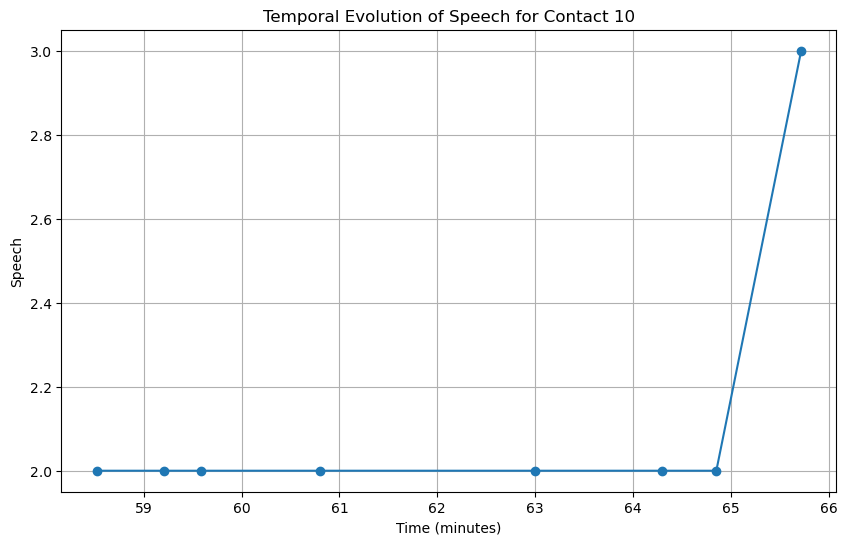

In [18]:
temporal_graph(STN1_df, 'Contact 10', 'Speech')

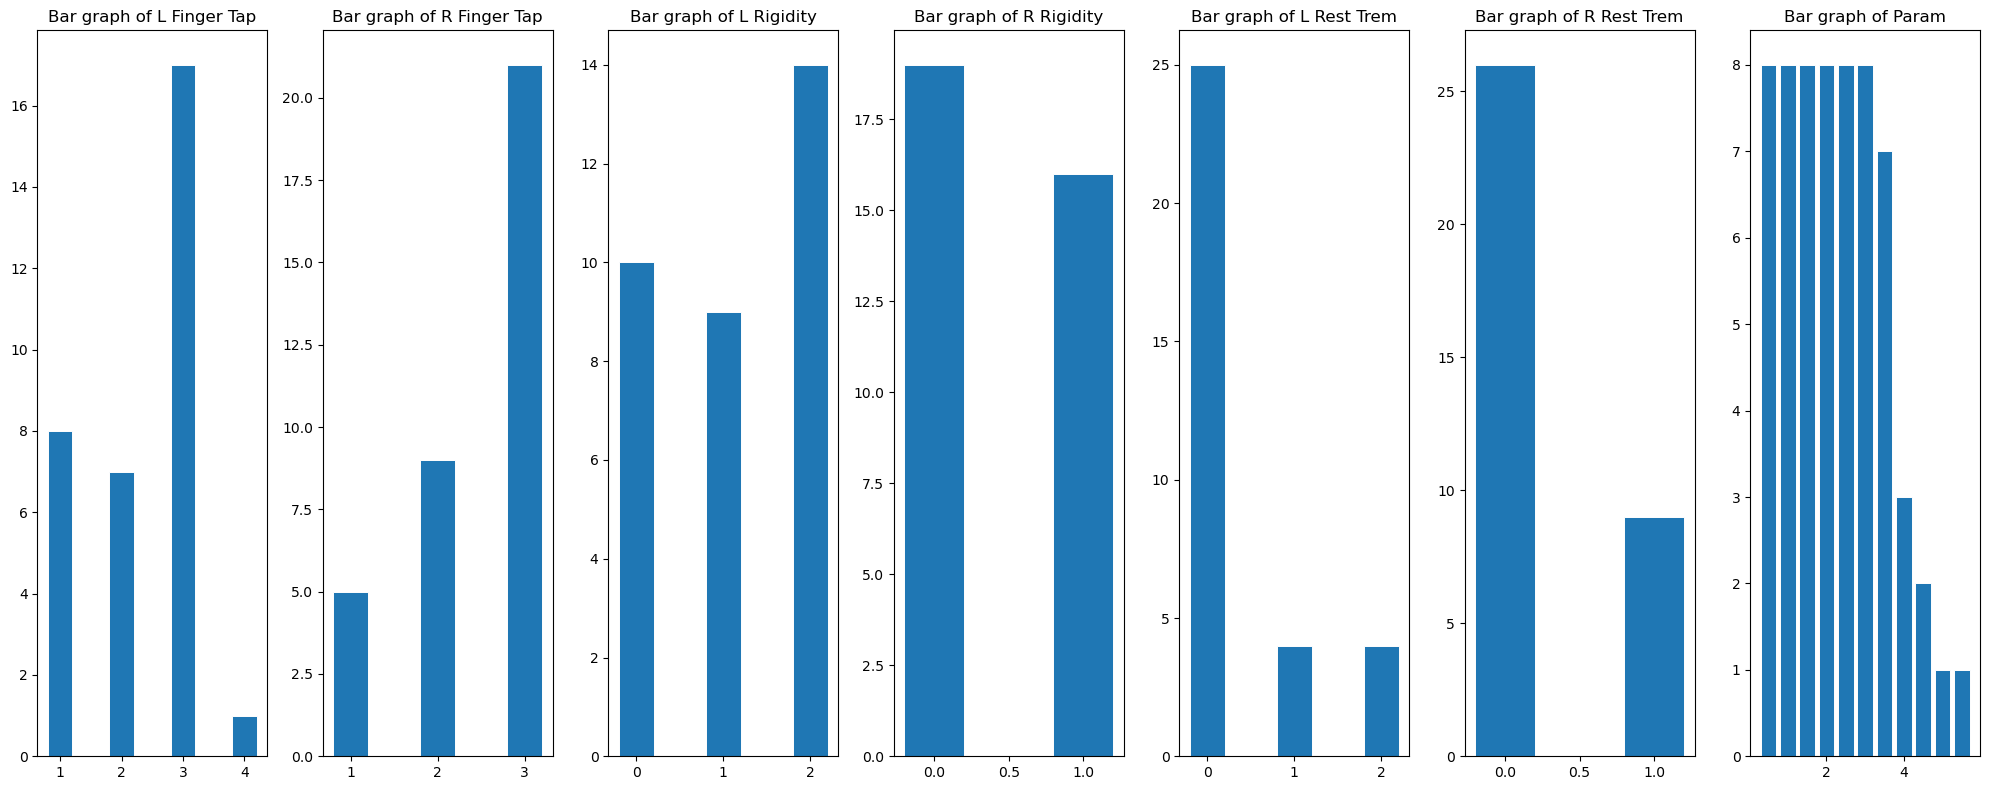

In [19]:
simple_barplot(STN1_df, np.concatenate((STN1_df.columns[1:7].values, STN1_df.columns[11:12].values)))

# Analysis

Overarching Goal: Create a virtual patient model

Ideas:
- Data compression/ Evaluate number of inputs needed
- Autoencoder latent representation
- Controlled level of noisiness vs. accuracy (i.e differential privary)

Legend for values of side effects:

 0: No side effects

 1: Side effect

 -2: Baseline off

 2: Baseline on

 3: Session's best / Baseline new
 

#TODO: Ask Juan about 'Baseline new'


## Data pre-processing

#TODO: Ask Juan about 2.3.4, or 6.7.8 Param entries...

Pre-processing steps:
1. Convert None, 0-4 scales -> 0-5 scales
2. Remove time, sheet name and test columns.

In [52]:
STN1_df.columns

Index(['Test', 'L Finger Tap', 'R Finger Tap', 'L Rigidity', 'R Rigidity',
       'L Rest Trem', 'R Rest Trem', 'Speech', 'Spiral', 'Notes', 'Time',
       'Param', 'Sheet Name'],
      dtype='object')

In [66]:
def preprocess_df(df):
    
    preprocessed_df = df.copy()

    # Step 1: Add +1 if the entry is not empty
    for col in ['L Finger Tap', 'R Finger Tap', 'L Rigidity', 'R Rigidity',
       'L Rest Trem', 'R Rest Trem']:
        
        preprocessed_df[col] = preprocessed_df[col].apply(lambda x: x + 1 if pd.notna(x) and x != 'NaN' else x)

    # Step 2: Replace None and empty values with 0
    preprocessed_df.fillna(0, inplace=True)


    preprocessed_df = preprocessed_df[['L Finger Tap', 'R Finger Tap', 'L Rigidity', 'R Rigidity',
       'L Rest Trem', 'R Rest Trem', 'Speech', 'Spiral', 'Notes',
       'Param']]

    return preprocessed_df

In [68]:
STN1_df = preprocess_df(STN1_df)
STN2_df = preprocess_df(STN2_df)
STN3_df = preprocess_df(STN3_df)
STN4_df = preprocess_df(STN4_df)
STN5_df = preprocess_df(STN5_df)
STN6_df = preprocess_df(STN6_df)

## model

Considerations:

1. Do PCA analysis to see if you can derive useful inputs
2. The number of components will guide to consider how many inputs you need... train on (x1, x2, ...., xk, side effect, spiral), but model will have patient(amplitude param) -> side effect, spiral
3. Autoencoder?
4. F-tests and ANOVA tables for your best models